<a href="https://colab.research.google.com/github/rallyfranky/my-first-repo/blob/main/numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


単回帰

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
from jax import random, vmap, grad, jit, lax
import numpyro
from numpyro import plate, sample
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist

In [43]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


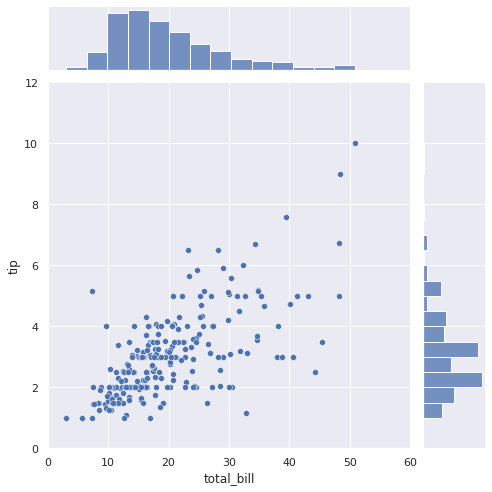

In [44]:
sns.set(style="darkgrid")
sns.jointplot(x="total_bill", y="tip", data=df,
              kind="scatter",
              xlim=(0, 60), ylim=(0, 12),
              color="b",
              height=7);

In [45]:
Y = df['tip'].values
X = df["total_bill"].values

In [52]:
 # 線形回帰モデルの設計
 def model(X, Y=None):
    pm_a = numpyro.sample('pm_a', dist.Normal(0.0, 10.0))
    pm_b = numpyro.sample('pm_b', dist.Normal(0.0, 10.0))
    
    mu = pm_a * X + pm_b
    sigma = 1.0

    pm_Y = numpyro.sample('pm_Y', dist.Normal(mu, sigma), obs=Y)

    return pm_Y 

In [53]:
# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)

# print MCMC summary（推定パラメータの基本統計量）
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 356.30it/s, 1 steps of size 3.03e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.11      0.01      0.11      0.10      0.12    322.43      1.01
      pm_b      0.90      0.16      0.90      0.64      1.16    320.04      1.01

Number of divergences: 0


In [54]:
# get param (num_samples=2000)
mcmc_samples = mcmc.get_samples()
pm_a = mcmc_samples["pm_a"]
pm_b = mcmc_samples["pm_b"]

# print("mcmc_samples:", mcmc_samples)
# print("pm_a:", pm_a)
# print("pm_b:", pm_b)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


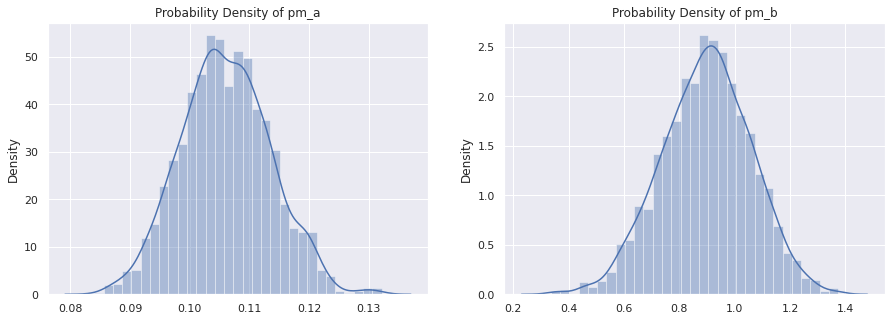

In [55]:
# 可視化
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(pm_a)
plt.title("Probability Density of pm_a")

plt.subplot(1, 2, 2)
sns.distplot(pm_b)
plt.title("Probability Density of pm_b")
plt.show()

In [57]:
X_range = jnp.linspace(0, 50, 50)

predictive = Predictive(model, mcmc_samples)
predict_samples = predictive(random.PRNGKey(0), X=X_range, Y=None)
# print(predict_samples)

pm_Y = predict_samples['pm_Y']
print(pm_Y)

[[ 2.140912    1.8607001   0.33420694 ...  4.373672    5.81839
   4.827458  ]
 [ 1.9509826   0.06253028  0.65995026 ...  6.9060545   4.378338
   6.9052105 ]
 [ 0.8882878   0.398387    0.9048197  ...  6.2469897   5.693128
   4.9603395 ]
 ...
 [ 1.0490074   2.3114252   0.11943413 ...  4.6688466   5.0860167
   5.961548  ]
 [ 2.0045114   1.1481854   2.073924   ...  5.907863    4.9878454
   6.43377   ]
 [-0.8690882   0.8997219   2.0573936  ...  6.903531    5.5008936
   5.539953  ]]


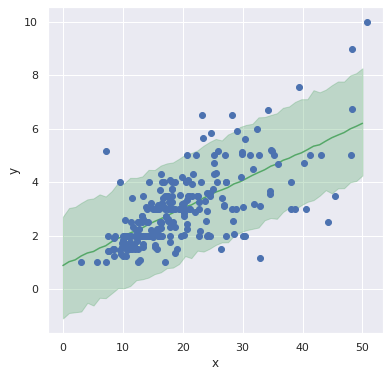

In [59]:
import numpy as np
mean_Y = pm_Y.mean(axis=0)
y_low, y_high = np.percentile(pm_Y, [2.5, 97.5], axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, '-', color='g')
plt.fill_between(X_range, y_low, y_high, color='g', alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.show()

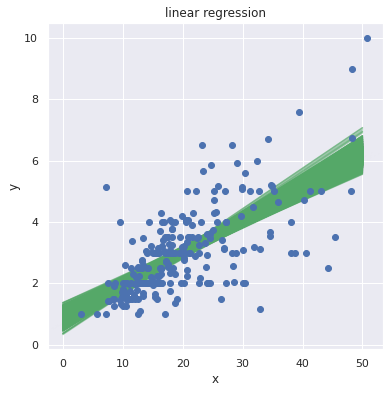

In [60]:
N = len(pm_a)
# X_range = jnp.linspace(0, 50, 50)

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
for i in range(N):
    pm_y = [pm_a[i] * x + pm_b[i] for x in X_range]
    plt.plot(X_range, pm_y, 'g-', alpha=0.5)

# データセットの可視化
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.title('linear regression')
plt.show()

ポワソン回帰

In [63]:
def model2 (X,Y=None):
  pm_a = numpyro.sample('pm_a', dist.Normal(0.0,10.0))
  pm_b = numpyro.sample('pm_b', dist.Normal(0.0,10.0))
  theta = pm_a * X + pm_b
  mu = jnp.exp(theta)

  numpyro.sample('pm_Y', dist.Poisson(mu), obs=Y)

In [65]:
kernel = NUTS(model2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 357.46it/s, 3 steps of size 2.42e-01. acc. prob=0.94] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.03      0.00      0.03      0.02      0.04    395.49      1.00
      pm_b      0.45      0.09      0.46      0.30      0.59    371.72      1.00

Number of divergences: 0


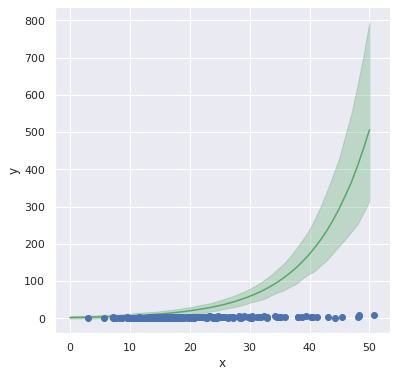

In [67]:
X_range = jnp.linspace(0, 50, 50)

predictive = Predictive(model2, mcmc_samples)
predict_samples = predictive(random.PRNGKey(0), X=X_range, Y=None)
# print(predict_samples)

pm_Y = predict_samples['pm_Y']
# print(pm_Y)

mean_Y = pm_Y.mean(axis=0)
y_low, y_high = np.percentile(pm_Y, [2.5, 97.5], axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, '-', color='g')
plt.fill_between(X_range, y_low, y_high, color='g', alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.show()